In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import music21
import chant21

import scipy
from scipy.fftpack import fft, dct, idct
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils.fixes import loguniform

import os
import sys
sys.path.append('../')
from helpers import cm2inch, title, show_grid
matplotlib.style.use('styles.mplstyle')

In [2]:
# We reuse code from the ISMIR 2020 paper
sys.path.append('../../ISMIR2020')
from src.classification import train_model, get_scores, read_predictions
from src.helpers import load_model
from src.tfidf_experiment import get_vectorizer

In [3]:
def load_data(genre, subset, kind, projection, segmentation, run, dim=1000):
    data_fn = f'../data/mode-classification/{run}.h5'
    key = f'{genre}_{subset}_{kind}_{segmentation}_{projection}'
    df = pd.read_hdf(data_fn, key=key)
    contours = df.map(lambda ch: ch[:, :dim])
    
    basis = pd.read_hdf(data_fn, key=f'{key}_basis').values
    return contours, basis

In [4]:
# Just to illustrate the data structure
_tmp_df, _ = load_data('responsory', 'full', 'test', 'pca', 'words', run='run-0', dim=2)
_tmp_df[0]

array([[ -0.334 ,   1.625 ],
       [ -3.658 , -12.15  ],
       [  8.086 ,  -2.697 ],
       [ -6.113 ,  -0.845 ],
       [-16.36  ,  -3.068 ],
       [  2.88  ,  -2.35  ],
       [ -7.24  ,  -5.76  ],
       [  0.5024,   3.293 ]], dtype=float16)

## Discretize contours

The pca and cosine projections are strongly correlated

In [5]:
df_pca, _ = load_data('responsory', 'full', 'test', 'pca', 'words', run='run-1', dim=2)
df_cos, _ = load_data('responsory', 'full', 'test', 'cos', 'words', run='run-1', dim=2)

Text(0, 0.5, 'PCA')

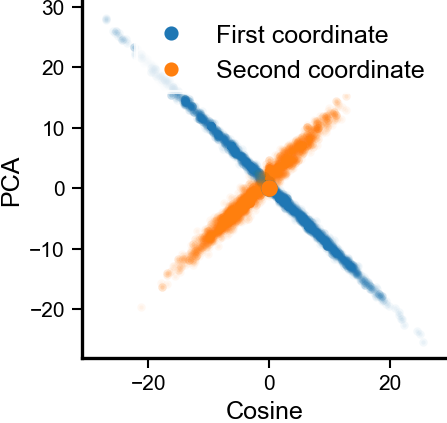

In [6]:
plt.figure(figsize=cm2inch(4, 4))
for i in range(200):
    plt.scatter(df_cos[i][:, 0], df_pca[i][:, 0], c='C0', s=1, alpha=.05)
    plt.scatter(df_cos[i][:, 1], df_pca[i][:, 1], c='C1', s=1, alpha=.05)
    
plt.plot([0],[0], 'o', c='C0', label='First coordinate')
plt.plot([0],[0], 'o', c='C1', label='Second coordinate')
plt.axis('equal')
plt.legend()
plt.xlabel('Cosine')
plt.ylabel('PCA')

### Visualize spaces

#### Cosine contours

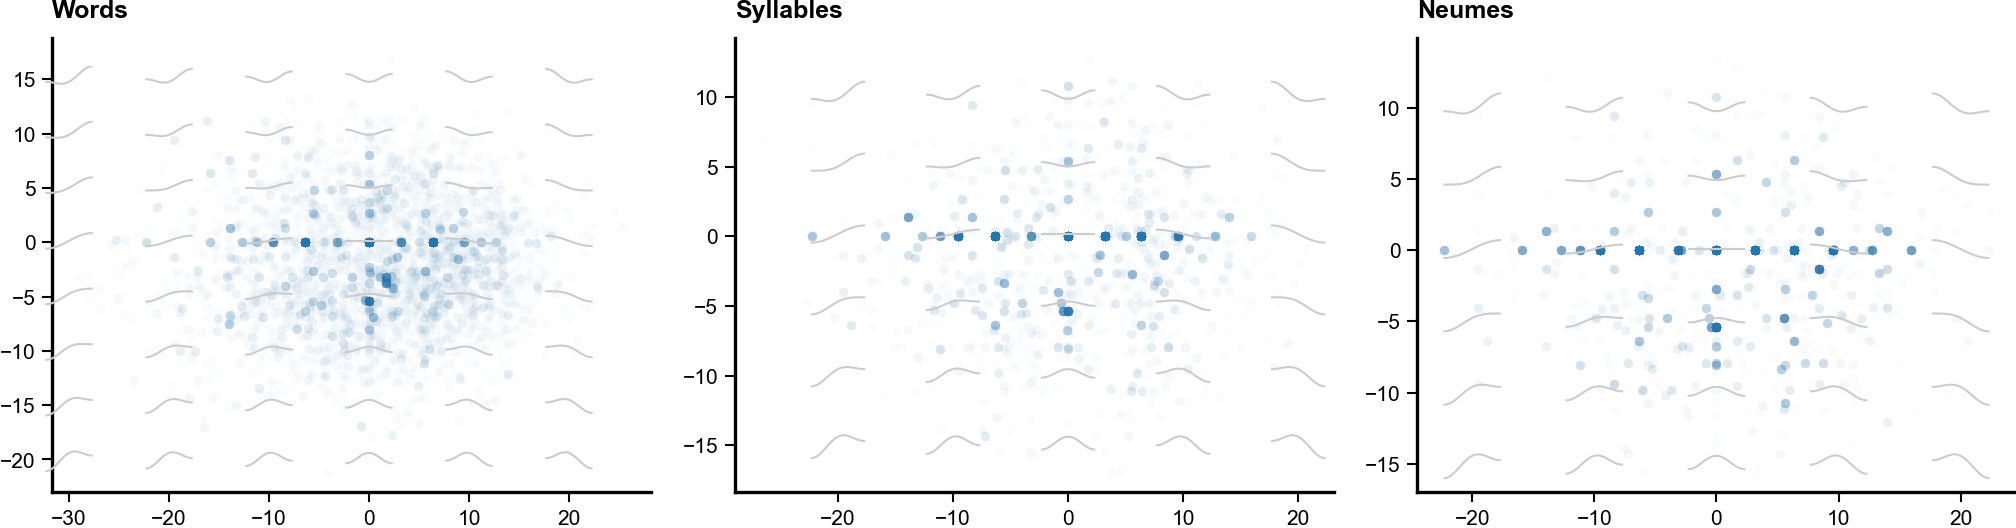

In [7]:
def show_scatter(segmentation, run, projection='cos', N = 6000, grid=True):
    df, basis = load_data('responsory', 'full', 'test', projection, segmentation, run=run, dim=2)
    all_contours = np.concatenate(df.values)
    plt.scatter(all_contours[:N, 0], all_contours[:N, 1], 
                alpha=.02, s=5, linewidths=0, zorder=2)
    if grid:
        show_grid(line_kws=dict(zorder=0), marker=False, basis=basis.T)

plt.figure(figsize=cm2inch(17.6, 5)) 
plt.subplot(131)
show_scatter('words', run='run-1')
title('Words')

plt.subplot(132)
show_scatter('syllables', run='run-1')
title('Syllables')

plt.subplot(133)
show_scatter('neumes', run='run-1')
title('Neumes')

plt.tight_layout()

#### PCA

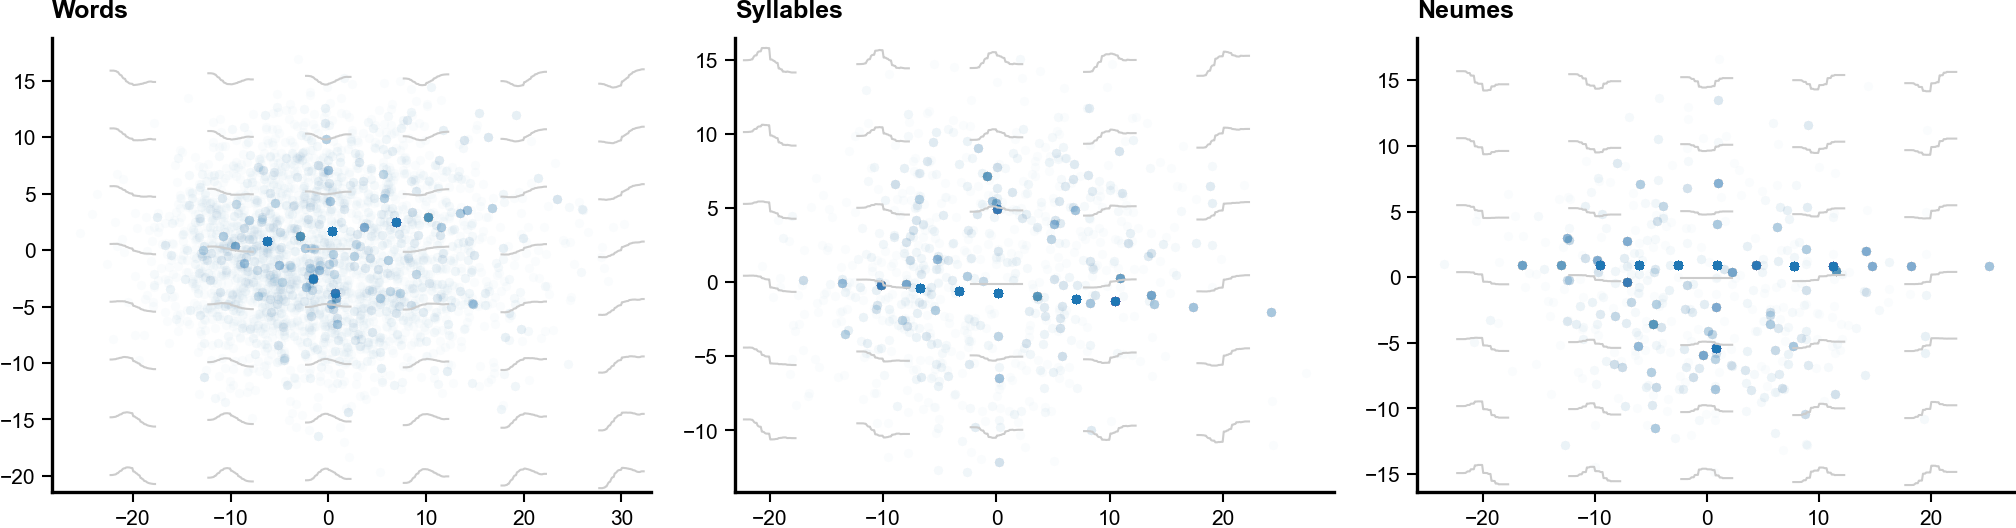

In [8]:
plt.figure(figsize=cm2inch(17.6, 5)) 
plt.subplot(131)
show_scatter('words', projection='pca', run='run-1')
title('Words')

plt.subplot(132)
show_scatter('syllables', projection='pca', run='run-1')
title('Syllables')

plt.subplot(133)
show_scatter('neumes', projection='pca', run='run-1')
title('Neumes')

plt.tight_layout()

### Discretize contours to a grid

In [9]:
class Grid(object):
    
    def __init__(self, minimum, maximum, delta, dim=2):
        self.delta = delta
        self.min = minimum
        self.max = maximum
        self.grid = np.arange(minimum-0.5, maximum+0.5, delta)
        
        if dim > 4:
            raise Exception('Dimension cannot be larger than 4')
        self.dim = dim
        
        coords = np.meshgrid(*[self.grid] * self.dim)
        points = list(zip(*[coord.ravel() for coord in coords]))
        self.oov_point = tuple([minimum - .5 - delta] * dim)
        self.oov_index = -1
        
        self.index_to_point = {i: tuple(p) for i, p in enumerate(points)}
        self.index_to_point[self.oov_index] = self.oov_point
        self.point_to_index = {p: i for i, p in self.index_to_point.items()}
        self.vocabulary_ = list(str(i) for i in self.index_to_point.keys())
        
    def index(self, point):
        point = np.asarray(point).round(1)
        return self.point_to_index.get(tuple(point), self.oov_index)
    
    def point(self, index):
        if index is False: return False
        return self.index_to_point[index]
    
    def discretize(self, points, return_indices=False):
        points = np.asarray(points)
        #assert points.shape[1] == self.dim

        corners = points - np.mod(points - self.min + 0.5, self.delta)
        corners = corners.round(1)
        
        if return_indices:
            if len(points.shape) > 1 and points.shape[1] > 1:
                return [self.index(c) for c in corners]
            else:
                return self.index(corners)
        else:
            return corners
    
    def stringify(self, points, skip_oov=True):
        indices = self.discretize(points, return_indices=True)
        if skip_oov:
            return " ".join(str(i) for i in indices if not i == self.oov_index)
        else:
            return " ".join(str(i) for i in indices)
    
    def unstringify(self, string, skip_oov=True):
        terms = string.split(" ")
        indices = [int(t) for t in terms]
        if skip_oov:
            return [i for i in indices if not i == self.oov_index]
        else: 
            return indices
        
    def get_vocabulary(self, skip_oov=True):
        if skip_oov:
            voc = [v for v in self.vocabulary_ if v != str(self.oov_index)]
        else: 
            voc = self.vocabulary_
        return voc
        
# grid = Grid(-20, 20, 2, dim=2)
# p = np.array([np.linspace(-5, 5, 50)]).T
# grid.discretize(p, return_indices=True).T
# grid = Grid(-20, 20, 2)
# chant = df.iloc[0]
# grid.discretize(chant, return_indices=True)
# grid.point(4)
# grid.unstringify(grid.stringify([[0, 0], [3, 0], [3, 1], [200, 1]]), skip_oov=False)
# grid.stringify([[0, 0], [3, 0], [3, 1], [200, 1]])

In [10]:
# # Test that our grid works as expected
# grid = Grid(-20, 20, 50)
# test_xx, test_yy = np.meshgrid(test_grid, test_grid)
# for x, y in zip(test_xx.ravel(), test_yy.ravel()):
#     point = np.array([x, y])
#     idx = point_to_index(point, grid)
#     coords = index_to_cell[idx]
#     for i in range(len(coords)):
#         assert coords[i] < point[i]
#         assert point[i] < coords[i] + delta

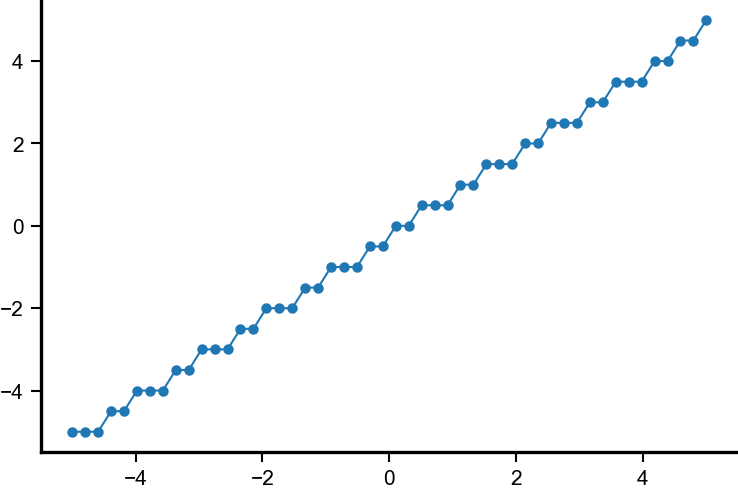

In [11]:
p = np.linspace(-5, 5, 50)
g = Grid(-20, 20, .5, dim=1)
cells = g.discretize(p)
plt.figure(figsize=(3, 2))
plt.plot(p, cells, '.-', lw=.5)

In [12]:
def discretize_chant(chant, grid):
    return grid.stringify(chant, skip_oov=True)

_grid = Grid(-20, 20, 1)
_df, _ = load_data('responsory', 'full', 'test', 'cos', 'words', run='run-0', dim=2)
discretize_chant(_df.iloc[0], _grid)

'840 264 725 711 660 639 506 882'

### Contour freqs

/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


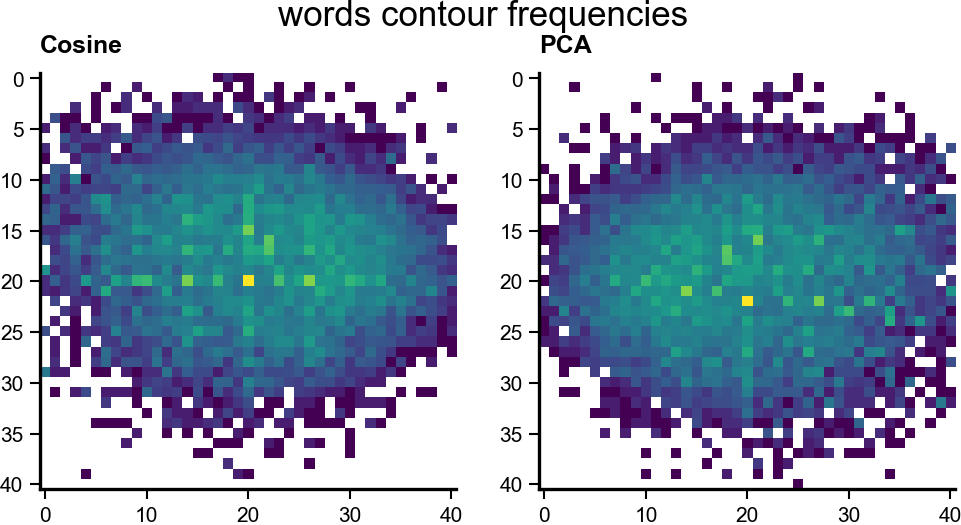

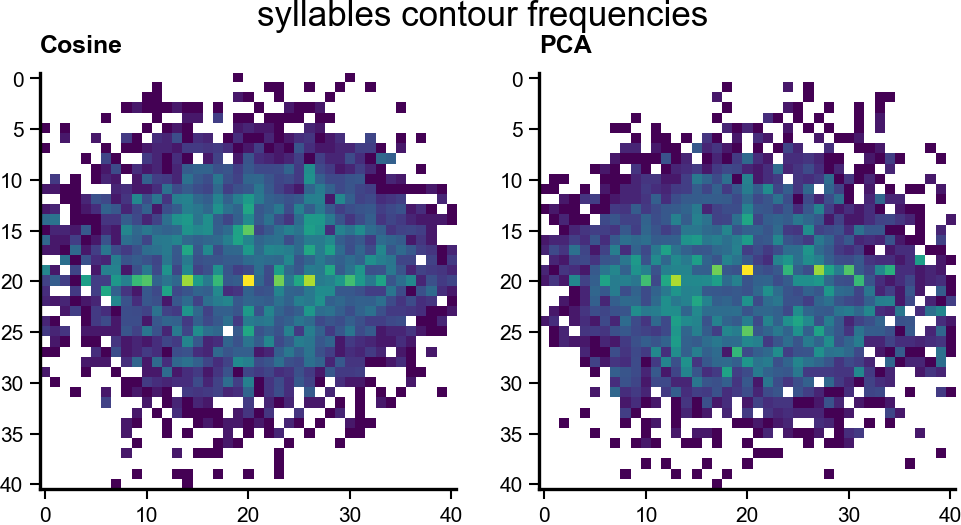

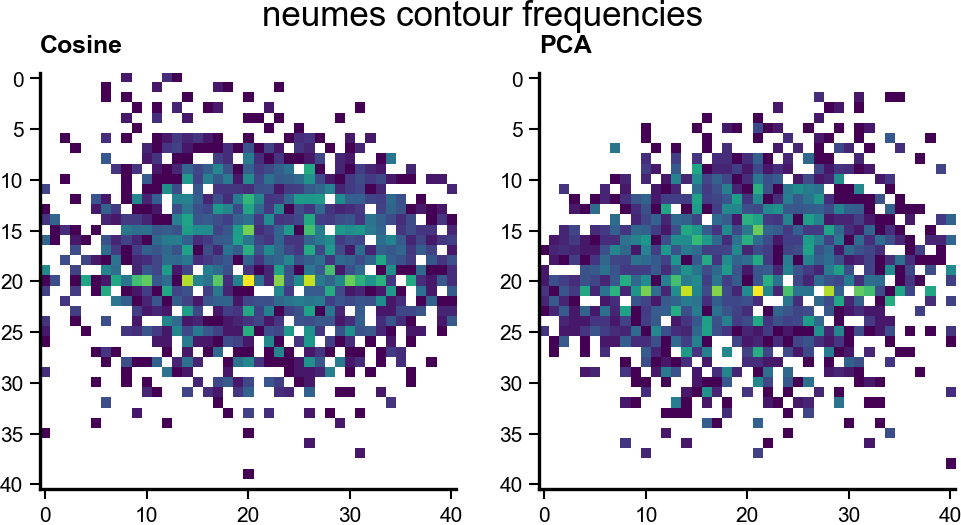

In [13]:
def show_cell_freqs_2d(df, grid):
    indices = grid.discretize(np.concatenate(df), return_indices=True)
    counts = pd.value_counts(indices)
    counts = [counts.get(int(i), 0) for i in grid.get_vocabulary(skip_oov=True)]
    n = len(grid.grid)
    plt.imshow(np.reshape(np.log(counts), (n, n)))
    
    
def compare_frequencies(segmentation, run):
    plt.figure(figsize=cm2inch(10, 5))
    grid = Grid(-20, 20, 1)

    plt.subplot(121)
    df, basis = load_data('responsory', 'full', 'test', 'cos', segmentation, run=run, dim=2)
    show_cell_freqs_2d(df, grid)
    title('Cosine')

    plt.subplot(122)
    df, basis = load_data('responsory', 'full', 'test', 'pca', segmentation, run=run, dim=2)
    show_cell_freqs_2d(df, grid)
    title('PCA')
    
    plt.suptitle(f'{segmentation} contour frequencies\n')

compare_frequencies('words', run='run-1')
compare_frequencies('syllables', run='run-1')
compare_frequencies('neumes', run='run-1')

## Classify!

In [14]:
def load_train_test(genre, subset, projection, segmentation, grid, dim, run):
    assert grid.dim == dim
    
    df_train, _ = load_data(genre, subset, 'train', projection, segmentation, dim=dim, run=run)
    X_train = df_train.apply(discretize_chant, grid=grid)
    
    y_train = pd.read_csv(
        f'../datasets/cornelissen-etal-2020/{run}/{genre}/{subset}/train-chants.csv', index_col=0)['mode']
    y_train = y_train[X_train.index]
    assert len(X_train) == len(y_train)
    
    df_test, _ = load_data(genre, subset, 'test', projection, segmentation, dim=dim, run=run)
    X_test = df_test.apply(discretize_chant, grid=grid)
    y_test = pd.read_csv(
        f'../datasets/cornelissen-etal-2020/{run}/{genre}/{subset}/test-chants.csv', index_col=0)['mode']
    y_test = y_test[X_test.index]
    assert len(X_test) == len(y_test)
    
    return (X_train, y_train), (X_test, y_test)

In [16]:
def get_model(grid):
    tfidf_params = dict(
        # Defaults
        strip_accents=None,
        stop_words=None,
        ngram_range=(1,1),

        max_df=1.0,
        min_df=1,
        max_features=5000,
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=False,

        lowercase=False,

        # This is crucial, as the default tokenization is inappropriate for
        # our data
        analyzer='word',
        token_pattern=r'[^ ]+',
        vocabulary=grid.get_vocabulary(skip_oov=True))

    svc_params = {
        'penalty': 'l2',
        'loss': 'squared_hinge',
        'multi_class': 'ovr',
        'random_state': np.random.randint(100)
    }
    tuned_params = {
        'clf__C': loguniform(1e-3, 1e4),
        'clf__dual': [True, False]
    }

    model = Pipeline([
        ('vect', TfidfVectorizer(**tfidf_params)),
        ('clf', LinearSVC(**svc_params)),
    ])
    return model, tuned_params

In [42]:
# Generate all datasets
refresh = False
for run in ['run-0', 'run-1', 'run-2']:
    for genre in ['responsory', 'antiphon']:
        for subset in ['full']:
            for projection in ['cos', 'pca']:
                for segmentation in ['words', 'syllables', 'neumes']:
                    for dim in [2]:
                        for delta in [.5, 1]:#, 2, 4]:
                            basepath = f'../data/mode-classification/results/{run}/{genre}-{subset}-{projection}-{segmentation}-{dim}d-{delta}'
                            if os.path.exists(f'{basepath}.model') and refresh is False:
                                print('Already exists:', basepath)
                                continue
                                
                            grid = Grid(-20, 20, delta, dim=dim)
                            (X_train, y_train), (X_test, y_test) = load_train_test(
                                genre, subset, projection, segmentation, run=run,
                                grid=grid, dim=grid.dim)
                            model, tuned_params = get_model(grid=grid)
                            train_model(
                                model,
                                train_data=X_train,
                                train_targets=y_train,
                                test_data=X_test,
                                test_targets=y_test,
                                param_grid=tuned_params,
                                n_splits=5,
                                n_iter=5,
                                basepath=basepath)

Already exists: ../data/mode-classification/results/run-0/responsory-full-cos-words-2d-0.5
Already exists: ../data/mode-classification/results/run-0/responsory-full-cos-words-2d-1
Already exists: ../data/mode-classification/results/run-0/responsory-full-cos-syllables-2d-0.5
Already exists: ../data/mode-classification/results/run-0/responsory-full-cos-syllables-2d-1
Already exists: ../data/mode-classification/results/run-0/responsory-full-cos-neumes-2d-0.5
Already exists: ../data/mode-classification/results/run-0/responsory-full-cos-neumes-2d-1
Already exists: ../data/mode-classification/results/run-0/responsory-full-pca-words-2d-0.5
Already exists: ../data/mode-classification/results/run-0/responsory-full-pca-words-2d-1
Already exists: ../data/mode-classification/results/run-0/responsory-full-pca-syllables-2d-0.5
Already exists: ../data/mode-classification/results/run-0/responsory-full-pca-syllables-2d-1
Already exists: ../data/mode-classification/results/run-0/responsory-full-pca-neum

/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Analysis

In [43]:
results = []
for run in ['run-0', 'run-1', 'run-2']:
    for genre in ['responsory', 'antiphon']:
        for subset in ['full']:#, 'full']:
            for projection in ['cos', 'pca']:
                for segmentation in ['words', 'syllables', 'neumes']:
                    for dim in [2]:#, 3]:
                        for delta in [.5, 1]:#.5, 1, 2, 4]:
                            grid = Grid(-20, 20, delta, dim=dim)
                            (X_train, y_train), (X_test, y_test) = load_train_test(
                                genre, subset, projection, segmentation, run=run,
                                grid=grid, dim=grid.dim)
                            pred_fn = f'../data/mode-classification/results/{run}/{genre}-{subset}-{projection}-{segmentation}-{dim}d-{delta}-test-pred.txt'
                            y_pred = read_predictions(pred_fn)

                            report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
                            report['accuracy'] = accuracy_score(y_test, y_pred)
                            report['delta'] = delta
                            report['dim'] = dim
                            report['segmentation'] = segmentation
                            report['projection'] = projection
                            report['subset'] = subset
                            report['genre'] = genre
                            report['run'] = run
                            results.append(report)
                            
results = pd.DataFrame(results)
results.to_csv('../data/mode-classification/results/report.csv')

/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [52]:
results = pd.read_csv('../data/mode-classification/results/report.csv')
accuracies = pd.pivot_table(results.query('projection=="cos"'),
               values='accuracy',
               columns='genre',
               index=['run', 'segmentation']) * 100
accuracies

genre                antiphon  responsory
run   segmentation                       
run-0 neumes        49.951900   72.983871
      syllables     52.188552   76.351992
      words         82.948533   73.814042
run-1 neumes        50.553151   72.722960
      syllables     52.380952   80.265655
      words         82.587783   73.078748
run-2 neumes        47.655123   75.592979
      syllables     53.282828   80.953510
      words         83.970659   71.513283

In [55]:
mean_accuracy = accuracies.groupby(level=['segmentation']).mean()
std = accuracies.groupby(level=['segmentation']).std()
mean_accuracy

genre,antiphon,responsory
segmentation,,
neumes,49.386724,73.766603
syllables,52.617444,79.190386
words,83.168992,72.802024


In [56]:
std

genre,antiphon,responsory
segmentation,,
neumes,1.529447,1.587059
syllables,0.584214,2.482065
words,0.717313,1.175077


In [57]:
orig_results = pd.DataFrame([
    [52, 30], 
    [76, 35],
    [81, 83],],
    columns=['responsory (orig)', 'antiphon (orig)'],
    index=['neumes', 'syllables', 'words'])

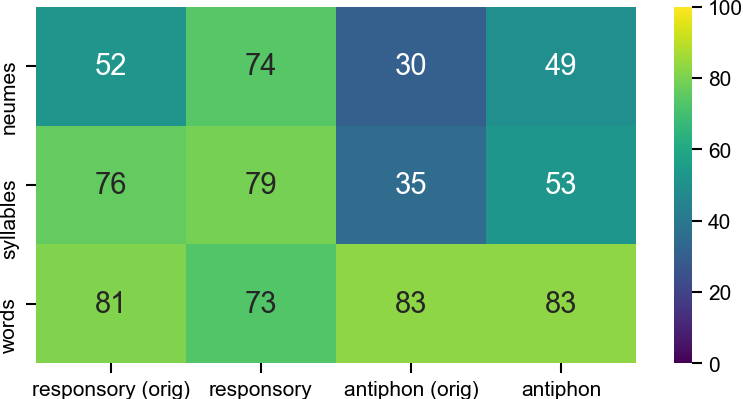

In [58]:
plt.figure(figsize=cm2inch(8.2, 4))
sns.heatmap(
    pd.concat([orig_results, mean_accuracy], axis=1)[
        ['responsory (orig)', 'responsory', 'antiphon (orig)', 'antiphon']
    ],
    annot=True,
    vmin=0, vmax=100, cmap='viridis'
)
plt.savefig('../figures/fig06/classification-results.pdf')

## Example chant

In [26]:
from matplotlib.colors import LogNorm

In [28]:
model = load_model('../data/mode-classification/results/run-1/responsory-full-cos-neumes-2d-1.model')
vect = model.named_steps['vect']

In [34]:
grid = Grid(-20, 20, delta, dim=dim)
(X_train, y_train), (X_test, y_test) = load_train_test(
    'responsory', 'full', 'cos', 'neumes', run='run-1',
    grid=grid, dim=grid.dim)

In [35]:
n = int(np.sqrt(vect.idf_.shape[0]))
X_trans = vect.transform(X_train).toarray()

In [36]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0, **kwargs):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha, **kwargs)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [37]:
def show_vector(vector, grid, scale=1, linewidths=0, **kwargs):
    n = len(grid.grid)
    mat = np.reshape(vector, (n, n))
    x, y = np.nonzero(mat)
    sizes = np.asarray(mat[x, y])
    plt.scatter(grid.grid[y]+.5, grid.grid[x]+.5,
        s=scale*10*np.sqrt(sizes), linewidths=linewidths, **kwargs)

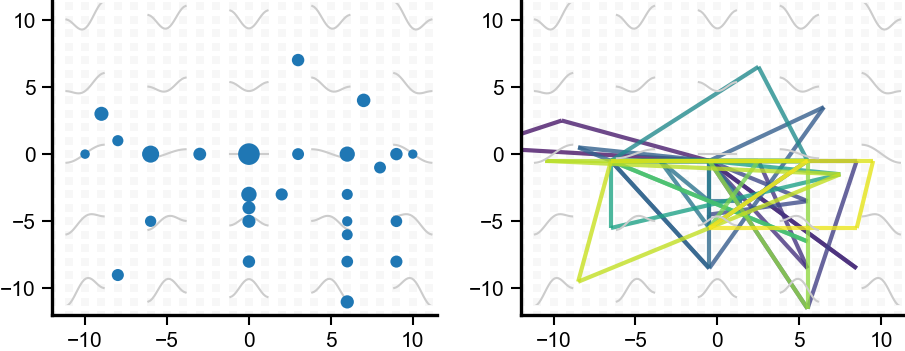

In [39]:
def show_vector(vector, grid, scale=1, linewidths=0, **kwargs):
    n = len(grid.grid)
    mat = np.reshape(vector, (n, n))
    x, y = np.nonzero(mat)
    sizes = np.asarray(mat[x, y])
    plt.scatter(grid.grid[y]+.5, grid.grid[x]+.5,
        s=scale*10*np.sqrt(sizes), linewidths=linewidths, **kwargs)
    
plt.figure(figsize=cm2inch(8.2, 3.5))
plt.subplot(121)
grid = Grid(-20, 20, 1)
show_vector(X_trans[1], grid, scale=3, zorder=10)
lim = 12
plt.ylim(-lim, lim-.5)
plt.xlim(-lim, lim-.5)

show_grid(marker=False)
cells = np.asarray(list(grid.index_to_point.values()))+0.5
plt.scatter(cells[:-1, 0], cells[:-1, 1], linewidths=0, 
            c='.97', s=4, marker='s', zorder=1)

plt.subplot(122)
points = np.array([grid.point(i) for i in grid.unstringify(X_train[1])])
colorline(points[:, 0], points[:, 1], cmap='viridis', linewidth=1, alpha=.8)
plt.ylim(-lim, lim-.5)
plt.xlim(-lim, lim-.5)
show_grid(marker=False)
plt.scatter(cells[:-1, 0], cells[:-1, 1], linewidths=0, 
            c='.97', s=3.5, marker='s', zorder=1)
plt.tight_layout()
plt.savefig('../figures/fig06/tfidf.pdf')

## Neumes

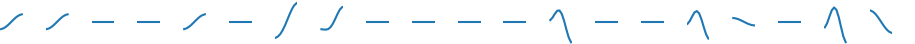

In [41]:
def show_neumes(points, num_points=10, w=.5, h = 1, 
                line_kws=dict(), ax=None, basis=None):
    if ax == None: ax = plt.gca()
    for i, coeffs in enumerate(points):
        axins = ax.inset_axes([i, 0, w, h], transform=ax.transData)
        if basis is None:
            basis = dct(np.eye(num_points), norm='ortho')[:, 1:]
        coeffs += [0.5, 0.5]
        curve = np.dot(basis[:, :len(coeffs)], coeffs)
        line_kwargs = dict(color='C0', linewidth=.5)
        line_kwargs.update(line_kws)
        axins.plot(curve, **line_kwargs)
        axins.axis('off')
        axins.set_ylim(-8, 8)
        
    plt.xlim(0, len(points))
    plt.axis('off')

points = np.array([grid.point(i) for i in grid.unstringify(X_train[1])])
plt.figure(figsize=cm2inch(10, .5))
show_neumes(points[:20])
plt.savefig('../figures/fig06/chant-neumes.pdf')

## Score

In [61]:
from music21 import converter
import chant21
chants = pd.read_csv(
        f'../../ISMIR2020/data/run-1/responsory/full/train-representation-pitch.csv', 
        index_col=0)

In [62]:
vol = chants['neumes'][1]
ch = converter.parse('1---'+vol.replace(' ', '---'), format='cantus')
ch.show('html')

conversion,"{'originalFormat': 'cantus/volpiano', 'converter': 'chant21', 'version': '0.4.6'}"
chant21version,0.4.6
